In [19]:
import kagglehub
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
import time
import kagglehub

In [28]:
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")
df = pd.read_csv(path + '/data.csv')

In [43]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


class SVM:
    def __init__(self, regularization, kernel, gamma_param=None, poly_degree=None):
        self.alpha = None
        self.C = regularization
        self.kernel = kernel
        self.gamma = gamma_param
        self.degree = poly_degree
        self.bias = 0

    def calculate_kernel(self, data_X, data_Y):
        if self.kernel == 'linear':
            return np.matmul(data_X, data_Y.T)  # Linear kernel computation
        if self.kernel == 'rbf':
            # Radial basis function kernel
            return np.exp(-self.gamma * np.sum((data_X[:, np.newaxis] - data_Y) ** 2, axis=2))
        if self.kernel == 'poly':
            # Polynomial kernel computation
            return (np.matmul(data_X, data_Y.T) + 1) ** self.degree

    def fit_model(self, training_X, training_y):
        # Generate the kernel matrix for training data
        K = self.calculate_kernel(training_X, training_X)
        # Optimize to find alpha values
        self.alpha = self._optimize_alphas(training_y, self.C, K)
        # Identify support vectors
        support_vector_mask = self.alpha > 1e-5
        self.support_vectors = training_X[support_vector_mask]
        self.support_labels = training_y[support_vector_mask]
        self.alpha = self.alpha[support_vector_mask]
        K_support = K[support_vector_mask][:, support_vector_mask]
        # Calculate bias term
        if self.kernel == 'linear':
            self.weights = np.sum(self.alpha[:, None] * self.support_labels[:, None] * self.support_vectors, axis=0)
            self.bias = np.mean(self.support_labels - np.dot(self.support_vectors, self.weights))
        else:
            self.bias = np.mean(
                self.support_labels - np.sum(self.alpha[:, None] * self.support_labels[:, None] * K_support, axis=0)
            )

    def predict_labels(self, inputs):
        # Compute kernel between inputs and support vectors
        K = self.calculate_kernel(inputs, self.support_vectors)
        if self.kernel == 'linear':
            decision = np.dot(inputs, self.weights) + self.bias  # Linear decision boundary
        else:
            decision = np.sum(self.alpha[:, None] * self.support_labels[:, None] * K.T, axis=0) + self.bias
        return np.sign(decision)  # Return class labels

    @staticmethod
    def _optimize_alphas(labels, C_param, kernel_matrix):
        # Setup optimization problem for alphas
        num_samples = len(labels)
        
        # Objective function: 0.5 * alpha^T * P * alpha - q^T * alpha
        P = np.outer(labels, labels) * kernel_matrix  # Quadratic coefficients
        q = -np.ones(num_samples)  # Linear coefficients
        
        # Equality constraint: sum(alpha_i * y_i) = 0
        constraints = {
            'type': 'eq',
            'fun': lambda alpha: np.dot(alpha, labels)
        }
        
        # Bounds for alpha: 0 <= alpha_i <= C
        bounds = [(0, C_param) for _ in range(num_samples)]
        
        # Initial guess
        initial_alpha = np.zeros(num_samples)
        
        # Objective function to minimize
        def objective(alpha):
            return 0.5 * np.dot(alpha, np.dot(P, alpha)) + np.dot(q, alpha)
        
        # Perform optimization
        result = minimize(objective, initial_alpha, bounds=bounds, constraints=constraints)
        
        if not result.success:
            raise ValueError("Optimization failed: " + result.message)
        
        return result.x  # Extract optimized alphas

    def visualize_decision_boundary(self, data_X, data_y, filename):
        # Define grid range
        x_min, x_max = data_X[:, 0].min() - 2, data_X[:, 0].max() + 2
        y_min, y_max = data_X[:, 1].min() - 2, data_X[:, 1].max() + 2
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
        grid = np.c_[xx.ravel(), yy.ravel()]
        # Predict on grid
        preds = self.predict_labels(grid).reshape(xx.shape)
        # Plot decision regions
        plt.contourf(xx, yy, preds, cmap=plt.cm.viridis, alpha=0.4)  # Updated colormap and transparency
        # Plot data points
        plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y, cmap=plt.cm.viridis, edgecolors='white', s=50)  # Changed marker style
        plt.title('SVM Decision Boundary')  # Added title
        plt.xlabel('Feature 1')  # X-axis label
        plt.ylabel('Feature 2')  # Y-axis label
        plt.grid(True)  # Enable grid
        plt.savefig(f"./img/{filename}.png")  # Save plot
        plt.close()

In [22]:
from sklearn import preprocessing

In [ ]:
# Prepare the dataframe for custom SVG visualization

# Select relevant features
features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean']

df_svg = df[features].dropna()

scaler_svg = preprocessing.MinMaxScaler()
df_svg_scaled = scaler_svg.fit_transform(df_svg)

# Convert to DataFrame
df_svg_prepared = pd.DataFrame(df_svg_scaled, columns=features)

df_svg_prepared.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean
0,0.521037,0.022658,0.545989,0.363733,0.593753
1,0.643144,0.272574,0.615783,0.501591,0.289880
2,0.601496,0.390260,0.595743,0.449417,0.514309
3,0.210090,0.360839,0.233501,0.102906,0.811321
4,0.629893,0.156578,0.630986,0.489290,0.430351


In [31]:
X = df[['radius_mean', 'texture_mean']].values
y = np.where(df['diagnosis'] == 'M', 1, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
kernels = ['linear', 'poly', 'rbf']
C_value = 0.1  # Reduced C value for better numerical stability
poly_degrees = [1, 2, 3]  # Different polynomial degrees

for kernel in kernels:
    if kernel == 'poly':
        for degree in poly_degrees:
            start = time.time()
            model = SVM(regularization=C_value, kernel=kernel, gamma_param=0.01, poly_degree=degree)
            model.fit_model(X_train, y_train)
            y_pred = model.predict_labels(X_test)
            exec_time = time.time() - start
            accuracy = (y_pred == y_test).mean()
            
            print(f"Kernel: {kernel}, Degree: {degree}")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Execution time: {exec_time:.2f} seconds")
            print("-" * 40)
            
            model.visualize_decision_boundary(X_test, y_test, f"svm_{kernel}_degree{degree}_boundary")
    else:
        start = time.time()
        if kernel == 'linear':
            model = SVM(regularization=C_value, kernel=kernel)
        else:
            model = SVM(regularization=C_value, kernel=kernel, gamma_param=0.01)
        
        model.fit_model(X_train, y_train)
        y_pred = model.predict_labels(X_test)
        exec_time = time.time() - start
        accuracy = (y_pred == y_test).mean()
        
        print(f"Kernel: {kernel}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Execution time: {exec_time:.2f} seconds")
        print("-" * 40)
        
        model.visualize_decision_boundary(X_test, y_test, f"svm_{kernel}_boundary")


Kernel: linear
Accuracy: 0.8947
Execution time: 5.89 seconds
----------------------------------------


C:\Users\pavel\AppData\Local\Temp\ipykernel_18168\2222501708.py:96: UserWarning: The following kwargs were not used by contour: 'label'
  contour = plt.contourf(xx, yy, preds, cmap=plt.cm.viridis, alpha=0.4, label='Decision Boundary')  # Updated colormap and transparency


Kernel: poly, Degree: 1
Accuracy: 0.8947
Execution time: 5.51 seconds
----------------------------------------
Kernel: poly, Degree: 2
Accuracy: 0.9035
Execution time: 6.76 seconds
----------------------------------------
Kernel: poly, Degree: 3
Accuracy: 0.9123
Execution time: 7.97 seconds
----------------------------------------
Kernel: rbf
Accuracy: 0.7456
Execution time: 18.01 seconds
----------------------------------------


Kernel: linear
Accuracy: 0.8070
Execution time: 0.02 seconds
----------------------------------------


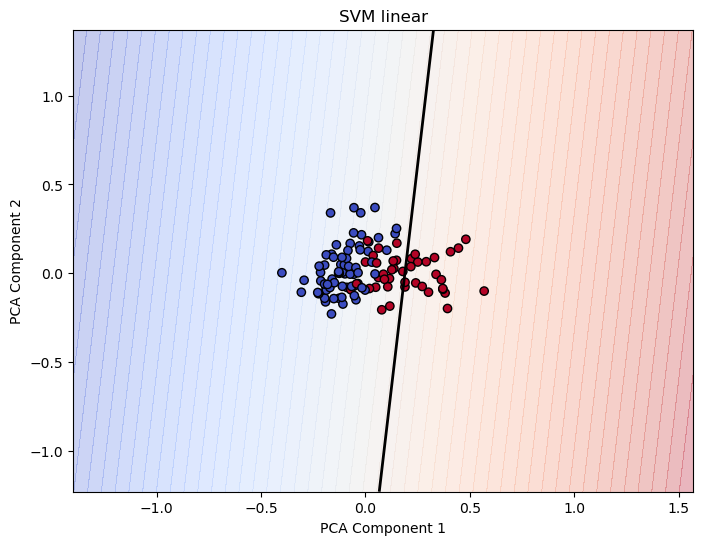

Kernel: poly, Degree: 1
Accuracy: 0.6228
Execution time: 0.02 seconds
----------------------------------------


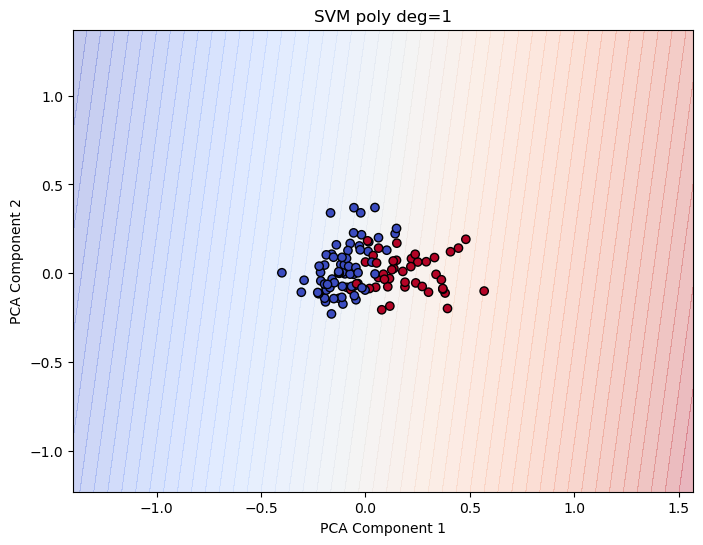

Kernel: poly, Degree: 2
Accuracy: 0.6228
Execution time: 0.02 seconds
----------------------------------------


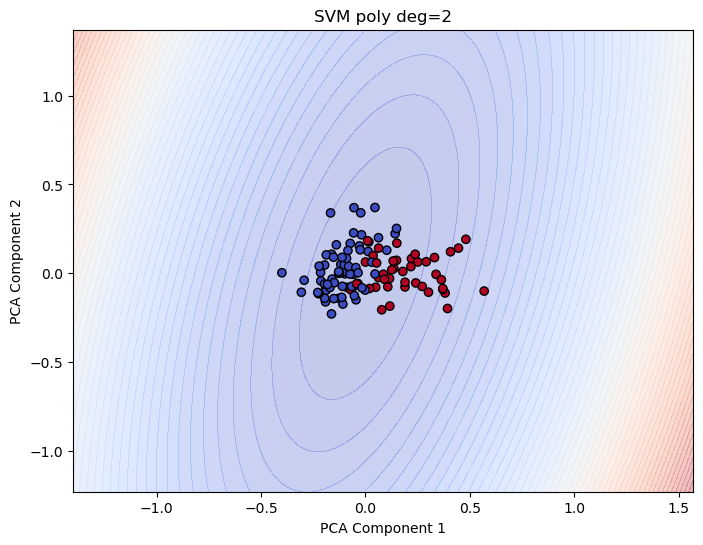

Kernel: poly, Degree: 3
Accuracy: 0.6228
Execution time: 0.02 seconds
----------------------------------------


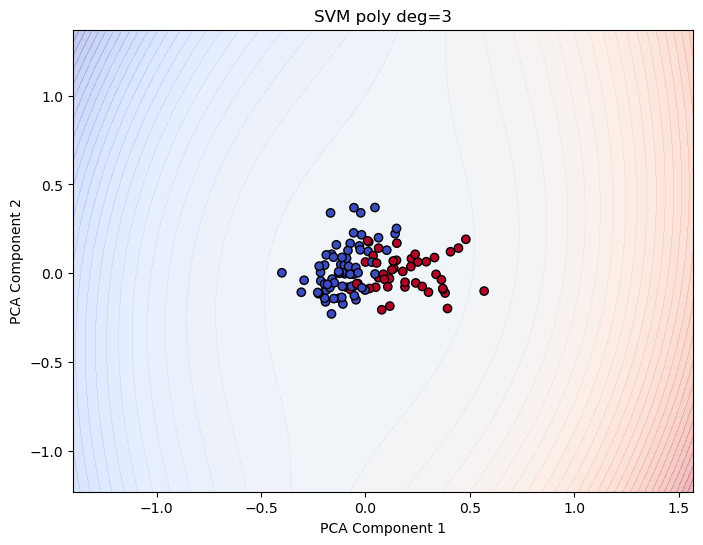

Kernel: rbf
Accuracy: 0.6228
Execution time: 0.04 seconds
----------------------------------------


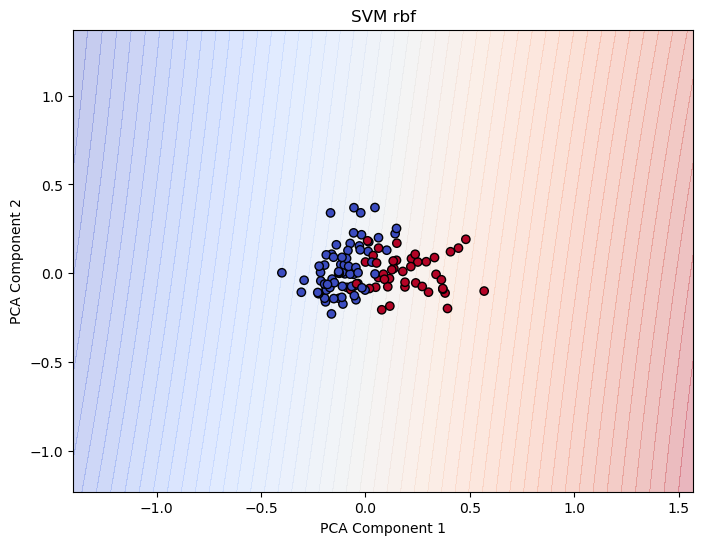

In [48]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

def visualize_decision_boundary(model, X, y, title):
    # Применение PCA-преобразования
    X_pca = X
    x_min, x_max = X_pca[:,0].min() - 1, X_pca[:,0].max() + 1
    y_min, y_max = X_pca[:,1].min() - 1, X_pca[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    # Фон классов
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50), cmap='coolwarm', alpha=0.3)
    # Граница решений (уровень 0)
    plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
    plt.scatter(X_pca[:,0], X_pca[:,1], c=y, edgecolors='k', cmap='coolwarm')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Применение PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

kernels = ['linear', 'poly', 'rbf']
C_value = 0.1
poly_degrees = [1, 2, 3]

for kernel in kernels:
    if kernel == 'poly':
        for degree in poly_degrees:
            start = time.time()
            model = SVC(C=C_value, kernel=kernel, gamma=0.01, degree=degree, probability=True)
            model.fit(X_train_pca, y_train)
            y_pred = model.predict(X_test_pca)
            exec_time = time.time() - start
            accuracy = accuracy_score(y_test, y_pred)

            print(f"Kernel: {kernel}, Degree: {degree}")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Execution time: {exec_time:.2f} seconds")
            print("-" * 40)

            visualize_decision_boundary(model, X_test_pca, y_test, f"SVM {kernel} deg={degree}")
    else:
        start = time.time()
        if kernel == 'linear':
            model = SVC(C=C_value, kernel=kernel, probability=True)
        else:
            model = SVC(C=C_value, kernel=kernel, gamma=0.01, probability=True)
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        exec_time = time.time() - start
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Kernel: {kernel}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Execution time: {exec_time:.2f} seconds")
        print("-" * 40)

        visualize_decision_boundary(model, X_test_pca, y_test, f"SVM {kernel}")
